Benchmarking policy gradient algorithms for different configurations. 

* Environments:
    * Discrete: CartPole-v1, Acrobot-v1, LunarLander-v2
    * Continuous: Reacher-v2, InvertedPendulum-v2, HalfCheetah-v2
    
* Search space:
    * Learning rate: [1e-4, 5e-4, 1e-3, 5e-3]
    * Learning rate scheduler: [True, False]
    * Discount factor: [0.95, 0.99, 0.995, 0.998]
    * Normalize observation and reward: [True, False]
    * Training trajectories: [1, 16, 32, 64]
    * Training timesteps: Sub-episodic or Complete episode
    * Standardize returns: [True, False]
    * Standardize advantage: [True, False]
    * Gradient clipping: [0.1, 0.5, 1.0, 10, 40]
    * Entropy coefficient: [0.01, 0.05, 0.1, 0.5, 1.0]
    * Value coefficient: [0.1, 0.5, 1.0, 2.0]
    * Initialization method: ['Orthogonal', 'Kaiming_normal', 'Xavier_normal']
    * Initialization scale: [0.01, 0.1, 1.0]
    * Nonlinearity: ['tanh', 'relu', 'selu']
    * Number of hidden neurons: [32, 64, 128]
    * Number of layers: [1, 2, 3]
    * Min standard deviation (Gaussian policy): [1e-6, 1e-5, 1e-2, 1e-1]
    * Constant standard deviation (Gaussian policy): [0.01, 0.1, 0.5, 1.0]
    * State dependency for standard deviation (Gaussian policy): [True, False]
    * Standard deviation parameterization (Gaussian policy): ['exp', 'softplus']
    * Initialization of standard deviation (Gaussian policy): [0.0, 0.01, 0.1]

# Table of contents
1. [REINFORCE](#1.-REINFORCE)
    - [Learning rate](#1.1.-Learning-rate)
    - [Learning rate scheduler](#1.2.-Learning-rate-scheduler)
    - [Discount factor](#1.3.-Discount-factor)
    - [Normalize observation and reward](#1.4.-Normalize-observation-and-reward)
    - [Training trajectories](#1.5.-Training-trajectories)
    - [Training timesteps](#1.6.-Training-timesteps)
    - [Standardize returns](#1.7.-Standardize-returns)
    - [Gradient clipping](#1.8.-Gradient-clipping)
    - [Entropy coefficient](#1.9.-Entropy-coefficient)
    - [Initialization method](#1.10.-Initialization-method)
    - [Initialization scale](#1.11.-Initialization-scale)
    - [Nonlinearity](#1.12.-Nonlinearity)
    - [Number of hidden neurons](#1.13.-Number-of-hidden-neurons)
    - [Number of layers](#1.14.-Number-of-layers)
    - Gaussian policy
        - [Min standard deviation](#1.15.-Min-standard-deviation)
        - [Constant standard deviation](#1.16.-Constant-standard-deviation)
        - [State dependency for standard deviation](#1.17.-State-dependency-for-standard-deviation)
        - [Standard deviation parameterization](#1.18.-Standard-deviation-parameterization)
        - [Initialization of standard deviation](#1.19.-Initialization-of-standard-deviation)
    
2. [VPG](#2.-VPG)
    - [Learning rate](#2.1.-Learning-rate)
    - [Learning rate scheduler](#2.2.-Learning-rate-scheduler)
    - [Discount factor](#2.3.-Discount-factor)
    - [Normalize observation and reward](#2.4.-Normalize-observation-and-reward)
    - [Training trajectories](#2.5.-Training-trajectories)
    - [Training timesteps](#2.6.-Training-timesteps)
    - [Standardize returns](#2.7.-Standardize-returns)
    - [Gradient clipping](#2.8.-Gradient-clipping)
    - [Entropy coefficient](#2.9.-Entropy-coefficient)
    - [Initialization method](#2.10.-Initialization-method)
    - [Initialization scale](#2.11.-Initialization-scale)
    - [Nonlinearity](#2.12.-Nonlinearity)
    - [Number of hidden neurons](#2.13.-Number-of-hidden-neurons)
    - [Number of layers](#2.14.-Number-of-layers)
    - [Value coefficient](#2.15.-Value-coefficient)
    - [Standardize advantage](#2.16.-Standardize-advantage)
    - Gaussian policy
        - [Min standard deviation](#2.17.-Min-standard-deviation)
        - [Constant standard deviation](#2.18.-Constant-standard-deviation)
        - [State dependency for standard deviation](#2.19.-State-dependency-for-standard-deviation)
        - [Standard deviation parameterization](#2.20.-Standard-deviation-parameterization)
        - [Initialization of standard deviation](#2.21.-Initialization-of-standard-deviation)
        
3. [A2C](#3.-A2C)
    - [Learning rate](#3.1.-Learning-rate)
    - [Learning rate scheduler](#3.2.-Learning-rate-scheduler)
    - [Discount factor](#3.3.-Discount-factor)
    - [Normalize observation and reward](#3.4.-Normalize-observation-and-reward)
    - [Training trajectories](#3.5.-Training-trajectories)
    - [Training timesteps](#3.6.-Training-timesteps)
    - [Standardize returns](#3.7.-Standardize-returns)
    - [Gradient clipping](#3.8.-Gradient-clipping)
    - [Entropy coefficient](#3.9.-Entropy-coefficient)
    - [Initialization method](#3.10.-Initialization-method)
    - [Initialization scale](#3.11.-Initialization-scale)
    - [Nonlinearity](#3.12.-Nonlinearity)
    - [Number of hidden neurons](#3.13.-Number-of-hidden-neurons)
    - [Number of layers](#3.14.-Number-of-layers)
    - [Value coefficient](#3.15.-Value-coefficient)
    - [Standardize advantage](#3.16.-Standardize-advantage)
    -  Gaussian policy
        - [Min standard deviation](#3.17.-Min-standard-deviation)
        - [Constant standard deviation](#3.18.-Constant-standard-deviation)
        - [State dependency for standard deviation](#3.19.-State-dependency-for-standard-deviation)
        - [Standard deviation parameterization](#3.20.-Standard-deviation-parameterization)
        - [Initialization of standard deviation](#3.21.-Initialization-of-standard-deviation)
        
4. [Benchmark REINFORCE/VPG/A2C](#4.-Benchmark-REINFORCE/VPG/A2C)

Import some common libraries

In [5]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from lagom.experiment import Config
from lagom.core.plotter import CurvePlot

Define some helper functions to read and process the logged information

In [206]:
from pathlib import Path
from glob import glob

def read_logging(log_folder, IDs, filename, keys):
    loggings = []
    
    # Iterate over given list of IDs
    for ID in IDs:
        # Initialize logging dictionary for current ID
        logging = {}
        
        # Glob all file names with same pattern
        filenames = glob(str(Path(log_folder) / f'{ID}' / f'{filename}:*'))
        # Sorted all file names according to the number after ':'
        filenames = sorted(filenames, key=lambda x: int(x.split(':')[-1].split('.')[0]))
        
        # Merge all data together as a list of objects, probably dictionaries
        data = []
        for f in filenames:
            data.append(*np.load(f))  # augment list to list
        
        # Iterate over all keys
        for key in keys:
            # Save corresponding loggings in each data item
            logging[key] = [d[key] for d in data]
        
        loggings.append(logging)
        
    return loggings

def read_xyvalues(log_folder, IDs):
    logs = read_logging(log_folder=log_folder, 
                        IDs=IDs, 
                        filename='eval', 
                        keys=['accumulated_trained_timesteps', 'average_return'])
    xvalues = [np.array(log['accumulated_trained_timesteps']).flatten() for log in logs]
    data = [np.array(log['average_return']).flatten() for log in logs]
    
    return xvalues, data

def compare_results(algo, top_log_folder, envs, compare_key, compare_values=None):
    """
    Compare results of different values of a certain configuration, for each environment with an
    individual plot. 
    
    Note that there should be only one varied configuration, not more. Because we will show the
    plots with number of trained environments and each plot have multiple curves, each corresponds
    to a value of the given configuration setting. 
    """
    # Fix number of plots in a row
    W = 3
    # Compute number of rows and columns given total number of environments
    nrows = len(envs)//W
    if len(envs) % W > 0:  # if there is division residual then increment by one to ensure start from 1
        nrows += 1
    ncols = min(W, len(envs))  # either pre-defined number of columns or when number of environments less than W
    # Create subplots for each environments
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
    if len(envs) == 1:  # make single axis as a list, useful for looping
        axes = [axes]
    else:  # flatten the axes
        axes = axes.flatten()
    
    # Iterate over all environment and axes pairs
    for env, ax in zip(envs, axes):     
        # Create Curve plotter
        plot = CurvePlot()
        
        # Read configurations
        configs = Config.to_pandas_dataframe(np.load(f'{top_log_folder}/{env}/configs.npy'))
        
        if compare_values is None:  # not given, so use all
            values = configs[compare_key].unique().tolist()
        else:
            values = compare_values
        
        # Iterate over all values for the given configuration key
        for value in values:
            # Get IDs
            IDs = Config.subset_configs(configs, {'env:id': [env], compare_key: [value]})['ID'].values
            # Read x-y values
            xvalues, data = read_xyvalues(f'{top_log_folder}/{env}', IDs)
            # Add to plotter
            plot.add(name=f'{algo} - {compare_key}: {value}', data=data, xvalues=xvalues)
        
        # Do plotting for this environment
        plot(ax=ax, 
             title=env, 
             xlabel='Timesteps', 
             ylabel='Mean Episode Reward', 
             num_tick=6, 
             xscale_magnitude=None)
        
    fig.tight_layout()

# 1. REINFORCE

## 1.1. Learning rate

In [212]:
log_folder = 'reinforce/logs/lr'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                     
True 0.0001  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/lr/CartPole-v1 0   0   
                                                                                                                                                                                                        1   4   
                                                                                                                                                                                                        2   8   
                                                                                                                                                                                                        3  12   
                                                                                                                                                                                                        4  16   
     0.0005  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/lr/CartPole-v1 0   1   
                                                                                                                                                                                                        1   5   
                                                                                                                                                                                                        2   9   
                                                                                                                                                                                                        3  13   
                                                                                                                                                                                                        4  17   
     0.0010  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/lr/CartPole-v1 0   2   
                                                                                                                                                                                                        1   6   
                                                                                                                                                                                                        2  10   
                                                                                                                                                                                                        3  14   
                                                                                                                                                                                                        4  18   
     0.0050  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/lr/CartPole-v1 0   3   
                                                                                                                                                                                                        1   7   
                                                                                                                                                                                                        2  11   
                       

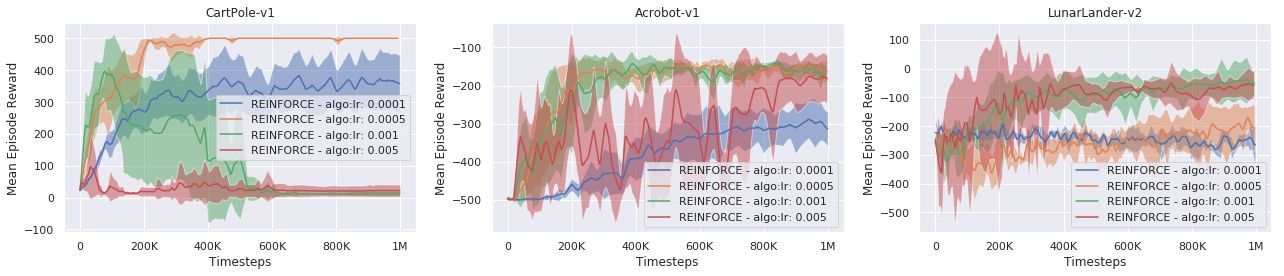

In [213]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'algo:lr'
compare_results('REINFORCE', log_folder, envs, compare_key)

## 1.2. Learning rate scheduler

In [216]:
log_folder = 'reinforce/logs/lr_scheduler'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                               
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/lr_scheduler/CartPole-v1 0   1   
                                                                                                                                                                                                                  1   3   
                                                                                                                                                                                                                  2   5   
                                                                                                                                                                                                                  3   7   
                                                                                                                                                                                                                  4   9   
                        True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/lr_scheduler/CartPole-v1 0   0   
                                                                                                                                                                                                                  1   2   
                                                                                                                                                                                                                  2   4   
                                                                                                                                                                                                                  3   6   
                                                                                                                                                                                                                  4   8   

                                                                                                                                                                                                                           seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                                      
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/lr_scheduler/CartPole-v1 0   144682090  
                                                                                                                                                                                                                  1   591442434  
                                                                                                                                                                                                                  2  1746958036  
                                                                                                                                                                                                                  3   338375070  
                                                                                                                                                                                                                  4   689208529  
  

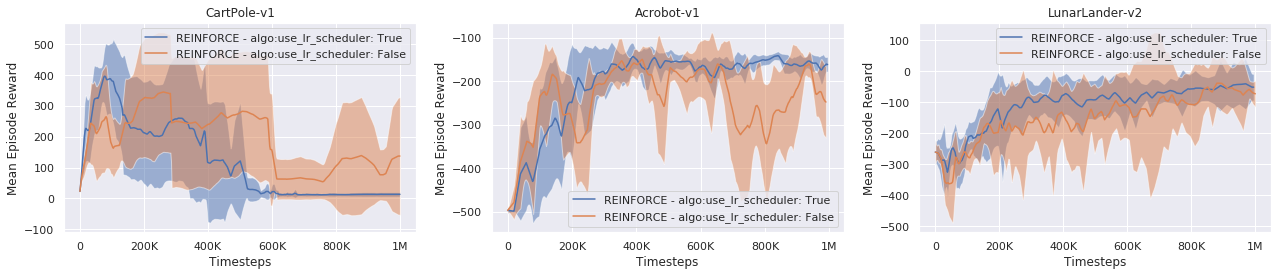

In [218]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'algo:use_lr_scheduler'
compare_results('REINFORCE', log_folder, envs, compare_key)

## 1.3. Discount factor

In [219]:
log_folder = 'reinforce/logs/gamma'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                        
True 0.001   0.950      False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/gamma/CartPole-v1 0   0   
                                                                                                                                                                                                           1   4   
                                                                                                                                                                                                           2   8   
                                                                                                                                                                                                           3  12   
                                                                                                                                                                                                           4  16   
             0.990      False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/gamma/CartPole-v1 0   1   
                                                                                                                                                                                                           1   5   
                                                                                                                                                                                                           2   9   
                                                                                                                                                                                                           3  13   
                                                                                                                                                                                                           4  17   
             0.995      False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/gamma/CartPole-v1 0   2   
                                                                                                                                                                                                           1   6   
                                                                                                                                                                                                           2  10   
                                                                                                                                                                                                           3  14   
                                                                                                                                                                                                           4  18   
             0.998      False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/gamma/CartPole-v1 0   3   
                                                                                                                                                                                                           1   7   
                                                                                                                                                                                  

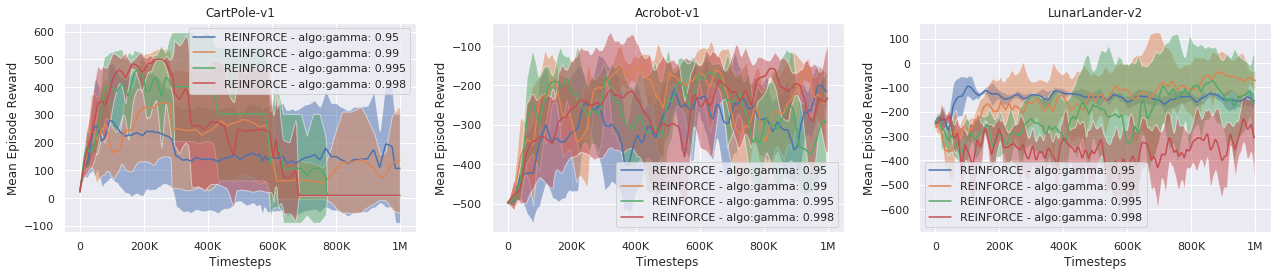

In [220]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'algo:gamma'
compare_results('REINFORCE', log_folder, envs, compare_key)

## 1.4. Normalize observation and reward

In [222]:
log_folder = 'reinforce/logs/env_normalize'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                                
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/env_normalize/CartPole-v1 0   1   
                                                                                                                                                                                                                   1   3   
                                                                                                                                                                                                                   2   5   
                                                                                                                                                                                                                   3   7   
                                                                                                                                                                                                                   4   9   
                                                          True          1000000.0      1       200     10     False             0.5                 0.01               100          logs/env_normalize/CartPole-v1 0   0   
                                                                                                                                                                                                                   1   2   
                                                                                                                                                                                                                   2   4   
                                                                                                                                                                                                                   3   6   
                                                                                                                                                                                                                   4   8   

                                                                                                                                                                                                                            seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                                       
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               100          logs/env_normalize/CartPole-v1 0   144682090  
                                                                                                                                                                                                                   1   591442434  
                                                                                                                                                                                                                   2  1746958036  
                                                                                                                                                                                                                   3   338375070  
                                                                                                                                                                                                                   

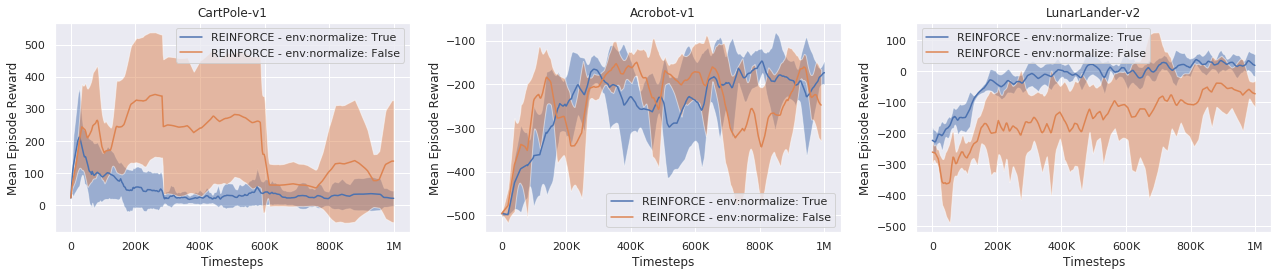

In [223]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'env:normalize'
compare_results('REINFORCE', log_folder, envs, compare_key)

## 1.5. Training trajectories

In [226]:
log_folder = 'reinforce/logs/train_N'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                          
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               10           logs/train_N/CartPole-v1 0   0   
                                                                                                                                                                                                             1   4   
                                                                                                                                                                                                             2   8   
                                                                                                                                                                                                             3  12   
                                                                                                                                                                                                             4  16   
                                                                                       16      200     10     False             0.5                 0.01               10           logs/train_N/CartPole-v1 0   1   
                                                                                                                                                                                                             1   5   
                                                                                                                                                                                                             2   9   
                                                                                                                                                                                                             3  13   
                                                                                                                                                                                                             4  17   
                                                                                       32      200     10     False             0.5                 0.01               10           logs/train_N/CartPole-v1 0   2   
                                                                                                                                                                                                             1   6   
                                                                                                                                                                                                             2  10   
                                                                                                                                                                                                             3  14   
                                                                                                                                                                                                             4  18   
                                                                                       64      200     10     False             0.5                 0.01               10           logs/train_N/CartPole-v1 0   3   
                                                                                                                                                                                                             1   7   
                                                                                                                                              

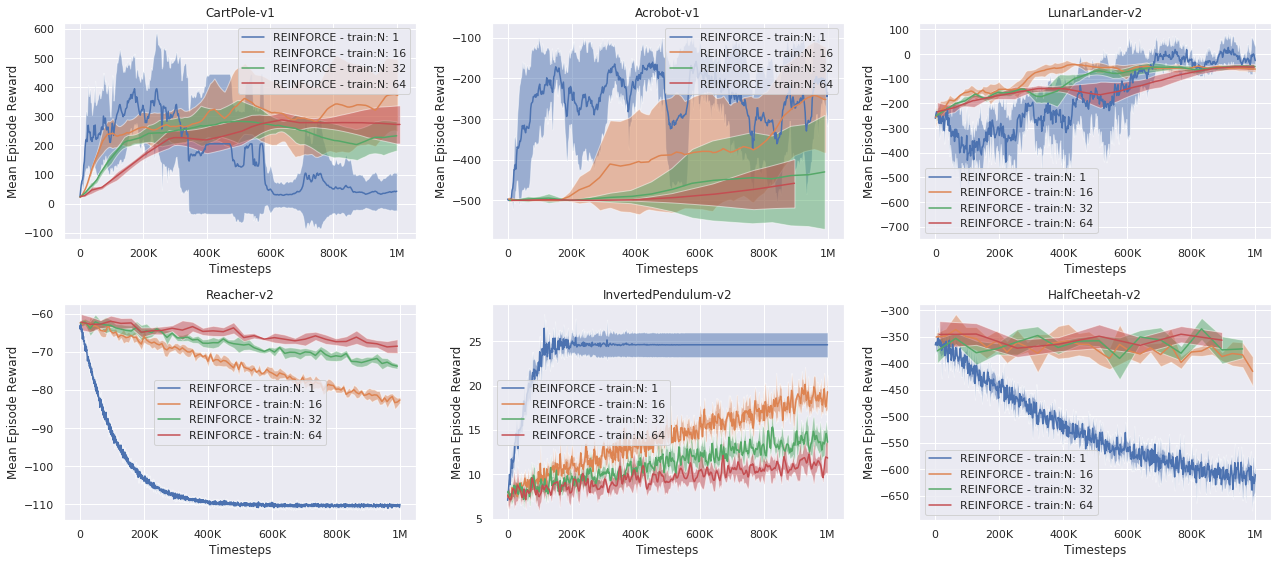

In [227]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2', 
        'Reacher-v2', 'InvertedPendulum-v2', 'HalfCheetah-v2']

compare_key = 'train:N'
compare_results('REINFORCE', log_folder, envs, compare_key)

## 1.6. Training timesteps

In [228]:
log_folder = 'reinforce/logs/train_T'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                          
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       250     10     False             0.5                 0.01               10           logs/train_T/CartPole-v1 0   0   
                                                                                                                                                                                                             1   2   
                                                                                                                                                                                                             2   4   
                                                                                                                                                                                                             3   6   
                                                                                                                                                                                                             4   8   
                                                                                               500     10     False             0.5                 0.01               10           logs/train_T/CartPole-v1 0   1   
                                                                                                                                                                                                             1   3   
                                                                                                                                                                                                             2   5   
                                                                                                                                                                                                             3   7   
                                                                                                                                                                                                             4   9   

                                                                                                                                                                                                                      seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                                 
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       250     10     False             0.5                 0.01               10           logs/train_T/CartPole-v1 0   144682090  
                                                                                                                                                                                                             1   591442434  
                                                                                                                                                                                                             2  1746958036  
                                                                                                                                                                                                             3   338375070  
                                                                                                                                                                                                             4   689208529  
                                                                                            

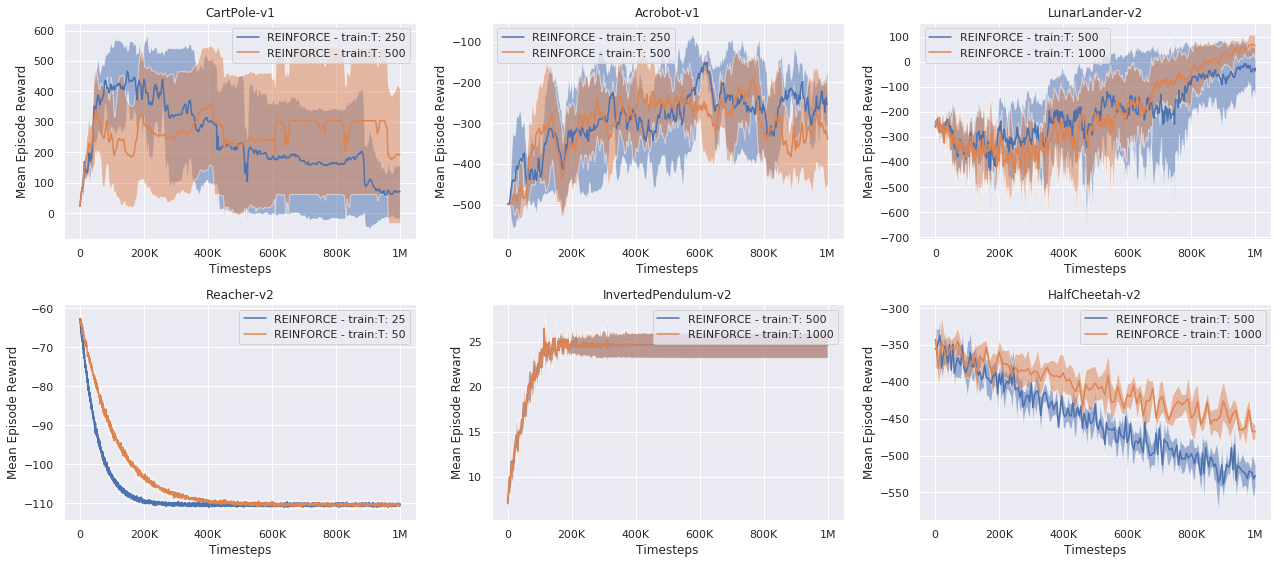

In [229]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2', 
        'Reacher-v2', 'InvertedPendulum-v2', 'HalfCheetah-v2']

compare_key = 'train:T'
compare_results('REINFORCE', log_folder, envs, compare_key)

## 1.7. Standardize returns

In [230]:
log_folder = 'reinforce/logs/agent_standardize'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                                    
True 0.0005  0.99       True                  CartPole-v1 False         1000000.0      1       500     10     False             0.5                 0.01               10           logs/agent_standardize/CartPole-v1 0   1   
                                                                                                                                                                                                                       1   3   
                                                                                                                                                                                                                       2   5   
                                                                                                                                                                                                                       3   7   
                                                                                                                                                                                                                       4   9   
                                                                                                              True              0.5                 0.01               10           logs/agent_standardize/CartPole-v1 0   0   
                                                                                                                                                                                                                       1   2   
                                                                                                                                                                                                                       2   4   
                                                                                                                                                                                                                       3   6   
                                                                                                                                                                                                                       4   8   

                                                                                                                                                                                                                                seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef log:interval log:dir                                           
True 0.0005  0.99       True                  CartPole-v1 False         1000000.0      1       500     10     False             0.5                 0.01               10           logs/agent_standardize/CartPole-v1 0   144682090  
                                                                                                                                                                                                                       1   591442434  
                                                                                                                                                                                                                       2  1746958036  
                                                                                                                                                                                                                       3   338375070  
                                                                                                                                               

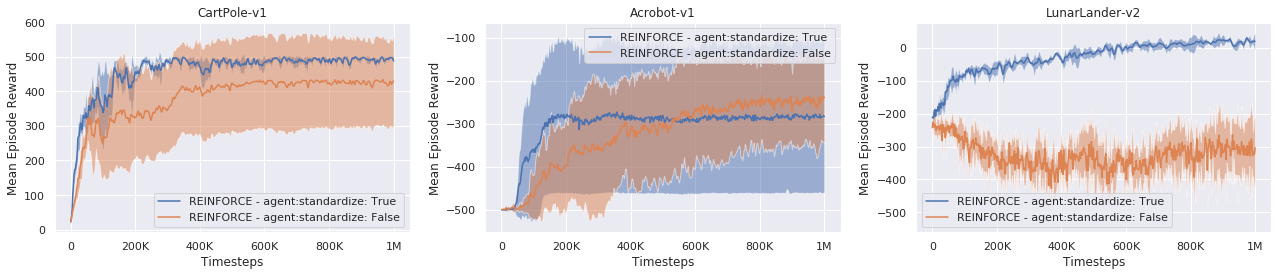

In [231]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'agent:standardize'
compare_results('REINFORCE', log_folder, envs, compare_key)

## 1.8. Gradient clipping

In [ ]:
log_folder = 'reinforce/logs/grad_clip'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.9. Entropy coefficient

In [ ]:
log_folder = 'reinforce/logs/entropy_coef'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.10. Initialization method

In [ ]:
log_folder = 'reinforce/logs/init_method'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.11. Initialization scale

In [ ]:
log_folder = 'reinforce/logs/init_scale'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.12. Nonlinearity

In [ ]:
log_folder = 'reinforce/logs/nonlinearity'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.13. Number of hidden neurons

In [ ]:
log_folder = 'reinforce/logs/hidden_neurons'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.14. Number of layers

In [ ]:
log_folder = 'reinforce/logs/hidden_layers'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.15. Min standard deviation

In [ ]:
log_folder = 'reinforce/logs/min_std'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.16. Constant standard deviation

In [ ]:
log_folder = 'reinforce/logs/constant_std'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.17. State dependency for standard deviation

In [ ]:
log_folder = 'reinforce/logs/std_state'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.18. Standard deviation parameterization

In [ ]:
log_folder = 'reinforce/logs/std_parameterization'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 1.19. Initialization of standard deviation

In [ ]:
log_folder = 'reinforce/logs/init_std'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

# 2. VPG

## 2.1. Learning rate

In [232]:
log_folder = 'vpg/logs/lr'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                     
True 0.0001  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              50           logs/lr/CartPole-v1 0   0   
                                                                                                                                                                                                                         1   4   
                                                                                                                                                                                                                         2   8   
                                                                                                                                                                                                                         3  12   
                                                                                                                                                                                                                         4  16   
     0.0005  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              50           logs/lr/CartPole-v1 0   1   
                                                                                                                                                                                                                         1   5   
                                                                                                                                                                                                                         2   9   
                                                                                                                                                                                                                         3  13   
                                                                                                                                                                                                                         4  17   
     0.0010  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              50           logs/lr/CartPole-v1 0   2   
                                                                                                                                                                                                                         1   6   
                                                                                                                                                                                                                         2  10   
                                                                                                                                                                                                                         3  14   
                                                                                                                                                                                                                         4  18   
     0.0050  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              50           logs/lr/CartPole-v1 0   3   
                                                                                                                                                        

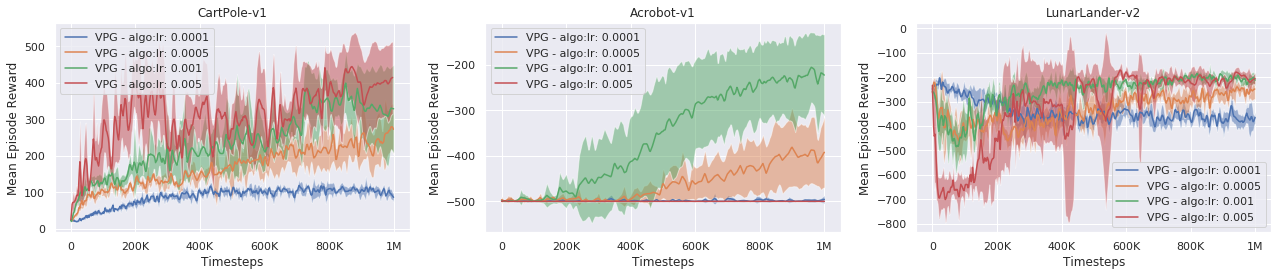

In [233]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'algo:lr'
compare_results('VPG', log_folder, envs, compare_key)

## 2.2. Learning rate scheduler

In [235]:
log_folder = 'vpg/logs/lr_scheduler'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                               
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/lr_scheduler/CartPole-v1 0   1   
                                                                                                                                                                                                                                   1   3   
                                                                                                                                                                                                                                   2   5   
                                                                                                                                                                                                                                   3   7   
                                                                                                                                                                                                                                   4   9   
                        True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/lr_scheduler/CartPole-v1 0   0   
                                                                                                                                                                                                                                   1   2   
                                                                                                                                                                                                                                   2   4   
                                                                                                                                                                                                                                   3   6   
                                                                                                                                                                                                                                   4   8   

                                                                                                                                                                                                                                            seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                      
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/lr_scheduler/CartPole-v1 0   144682090  
                                                                                                                                                                                                                                   1   591442434  
                                                                                                                                                                                                                                   2  1746958036  
                                                                                                                                                                                      

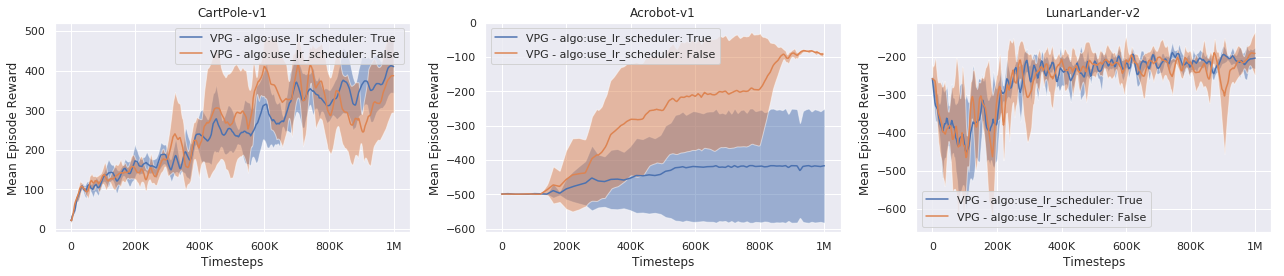

In [236]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'algo:use_lr_scheduler'
compare_results('VPG', log_folder, envs, compare_key)

## 2.3. Discount factor

In [237]:
log_folder = 'vpg/logs/gamma'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                        
True 0.001   0.950      False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/gamma/CartPole-v1 0   0   
                                                                                                                                                                                                                            1   4   
                                                                                                                                                                                                                            2   8   
                                                                                                                                                                                                                            3  12   
                                                                                                                                                                                                                            4  16   
             0.990      False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/gamma/CartPole-v1 0   1   
                                                                                                                                                                                                                            1   5   
                                                                                                                                                                                                                            2   9   
                                                                                                                                                                                                                            3  13   
                                                                                                                                                                                                                            4  17   
             0.995      False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/gamma/CartPole-v1 0   2   
                                                                                                                                                                                                                            1   6   
                                                                                                                                                                                                                            2  10   
                                                                                                                                                                                                                            3  14   
                                                                                                                                                                                                                            4  18   
             0.998      False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/gamma/CartPole-v1 0   3   
                                                                                                     

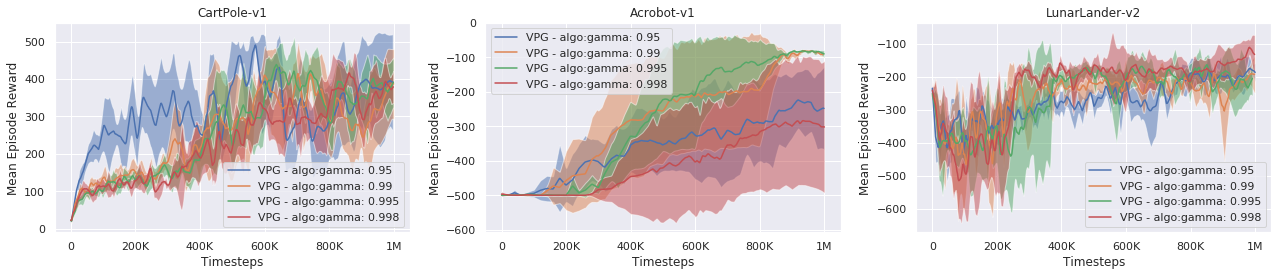

In [238]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'algo:gamma'
compare_results('VPG', log_folder, envs, compare_key)

## 2.4. Normalize observation and reward

In [239]:
log_folder = 'vpg/logs/env_normalize'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/env_normalize/CartPole-v1 0   1   
                                                                                                                                                                                                                                    1   3   
                                                                                                                                                                                                                                    2   5   
                                                                                                                                                                                                                                    3   7   
                                                                                                                                                                                                                                    4   9   
                                                          True          1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/env_normalize/CartPole-v1 0   0   
                                                                                                                                                                                                                                    1   2   
                                                                                                                                                                                                                                    2   4   
                                                                                                                                                                                                                                    3   6   
                                                                                                                                                                                                                                    4   8   

                                                                                                                                                                                                                                             seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                       
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/env_normalize/CartPole-v1 0   144682090  
                                                                                                                                                                                                                                    1   591442434  
                                                                                                                                                                                                                                    2  1746958036  
                                                                                                                                                                      

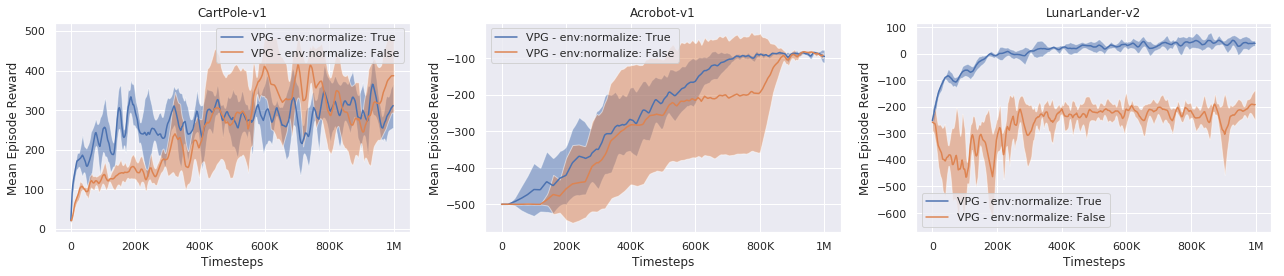

In [240]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'env:normalize'
compare_results('VPG', log_folder, envs, compare_key)

## 2.5. Training trajectories

In [241]:
log_folder = 'vpg/logs/train_N'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                          
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              10           logs/train_N/CartPole-v1 0   0   
                                                                                                                                                                                                                              1   4   
                                                                                                                                                                                                                              2   8   
                                                                                                                                                                                                                              3  12   
                                                                                                                                                                                                                              4  16   
                                                                                       16      200     10     False             0.5                 0.01               0.5              10           logs/train_N/CartPole-v1 0   1   
                                                                                                                                                                                                                              1   5   
                                                                                                                                                                                                                              2   9   
                                                                                                                                                                                                                              3  13   
                                                                                                                                                                                                                              4  17   
                                                                                       32      200     10     False             0.5                 0.01               0.5              10           logs/train_N/CartPole-v1 0   2   
                                                                                                                                                                                                                              1   6   
                                                                                                                                                                                                                              2  10   
                                                                                                                                                                                                                              3  14   
                                                                                                                                                                                                                              4  18   
                                                                                       64      200     10     False             0.5                 0.01               0.5              10           logs/train_N/CartPole-v1 0   3   
                                                                   

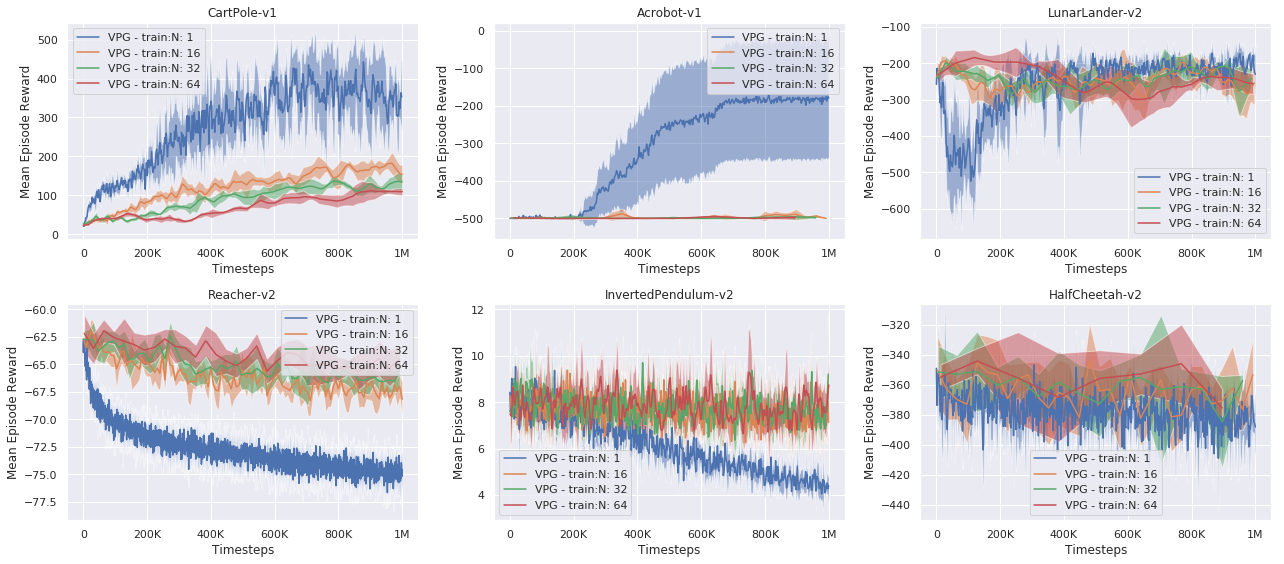

In [242]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2', 
        'Reacher-v2', 'InvertedPendulum-v2', 'HalfCheetah-v2']

compare_key = 'train:N'
compare_results('VPG', log_folder, envs, compare_key)

## 2.6. Training timesteps

In [ ]:
log_folder = 'vpg/logs/train_T'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.7. Standardize returns

In [243]:
log_folder = 'vpg/logs/agent_standardize/'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                    
True 0.0005  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/agent_standardize/CartPole-v1 0   1   
                                                                                                                                                                                                                                        1   3   
                                                                                                                                                                                                                                        2   5   
                                                                                                                                                                                                                                        3   7   
                                                                                                                                                                                                                                        4   9   
                                                                                                              True              0.5                 0.01               0.5              100          logs/agent_standardize/CartPole-v1 0   0   
                                                                                                                                                                                                                                        1   2   
                                                                                                                                                                                                                                        2   4   
                                                                                                                                                                                                                                        3   6   
                                                                                                                                                                                                                                        4   8   

                                                                                                                                                                                                                                                 seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                           
True 0.0005  0.99       True                  CartPole-v1 False         1000000.0      1       200     10     False             0.5                 0.01               0.5              100          logs/agent_standardize/CartPole-v1 0   144682090  
                                                                                                                                                                                                                                        1   591442434  
                                                                                                                                                                                                                                        2  1746958036  
                                                                                                      

KeyboardInterrupt: 

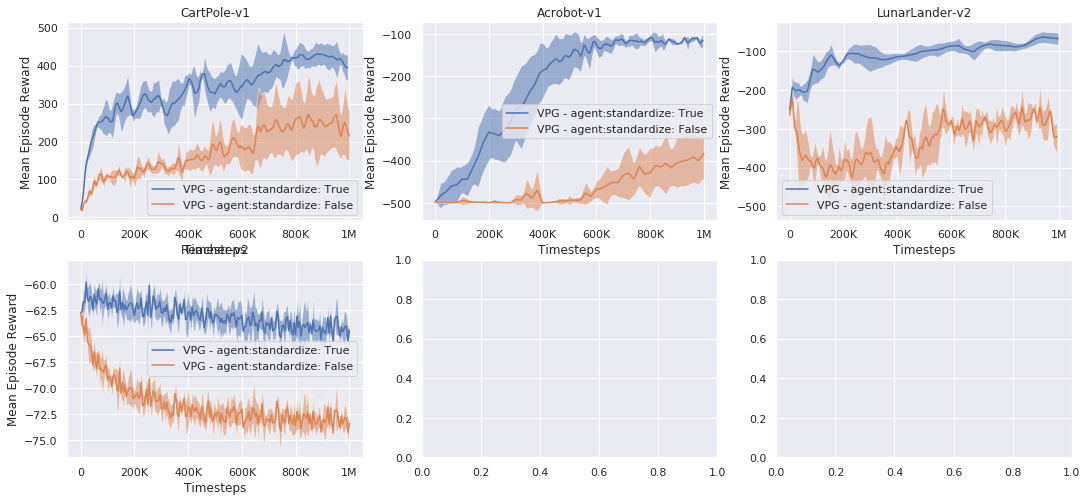

In [244]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2', 
        'Reacher-v2', 'InvertedPendulum-v2', 'HalfCheetah-v2']

compare_key = 'agent:standardize'
compare_results('VPG', log_folder, envs, compare_key)

## 2.8. Gradient clipping

In [ ]:
log_folder = 'vpg/logs/grad_clip'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.9. Entropy coefficient

In [ ]:
log_folder = 'vpg/logs/entropy_coef'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.10. Initialization method

In [ ]:
log_folder = 'vpg/logs/init_method'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.11. Initialization scale

In [ ]:
log_folder = 'vpg/logs/init_scale'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.12. Nonlinearity

In [ ]:
log_folder = 'vpg/logs/nonlinearity'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.13. Number of hidden neurons

In [ ]:
log_folder = 'vpg/logs/hidden_neurons'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.14. Number of layers

In [ ]:
log_folder = 'vpg/logs/hidden_layers'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.15. Value coefficient

In [ ]:
log_folder = 'vpg/logs/value_coef'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.16. Standardize advantage

In [ ]:
log_folder = 'vpg/logs/standardize_adv'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.17. Min standard deviation

In [ ]:
log_folder = 'vpg/logs/min_std'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.18. Constant standard deviation

In [ ]:
log_folder = 'vpg/logs/constant_std'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.19. State dependency for standard deviation

In [ ]:
log_folder = 'vpg/logs/std_state'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.20. Standard deviation parameterization

In [ ]:
log_folder = 'vpg/logs/std_parameterization'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 2.21. Initialization of standard deviation

In [ ]:
log_folder = 'vpg/logs/init_std'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

# 3. A2C

## 3.1. Learning rate

In [78]:
log_folder = 'a2c/logs/lr'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                     
True 0.0001  0.99       True                  CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/lr/CartPole-v1 0   0   
                                                                                                                                                                                                                         1   4   
                                                                                                                                                                                                                         2   8   
                                                                                                                                                                                                                         3  12   
                                                                                                                                                                                                                         4  16   
     0.0005  0.99       True                  CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/lr/CartPole-v1 0   1   
                                                                                                                                                                                                                         1   5   
                                                                                                                                                                                                                         2   9   
                                                                                                                                                                                                                         3  13   
                                                                                                                                                                                                                         4  17   
     0.0010  0.99       True                  CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/lr/CartPole-v1 0   2   
                                                                                                                                                                                                                         1   6   
                                                                                                                                                                                                                         2  10   
                                                                                                                                                                                                                         3  14   
                                                                                                                                                                                                                         4  18   
     0.0050  0.99       True                  CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/lr/CartPole-v1 0   3   
                                                                                                                                                        

algo:lr: [0.0001, 0.0005, 0.001, 0.005]


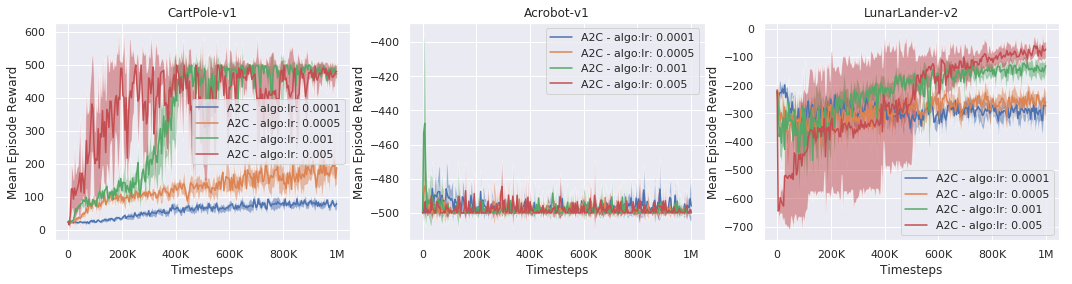

In [79]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'algo:lr'
compare_values = configs[compare_key].unique().tolist()
print(f'{compare_key}: {compare_values}')

compare_results('A2C', log_folder, envs, compare_key, compare_values)

## 3.2. Learning rate scheduler

In [101]:
log_folder = 'a2c/logs/lr_scheduler'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                               
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/lr_scheduler/CartPole-v1 0   1   
                                                                                                                                                                                                                                   1   3   
                                                                                                                                                                                                                                   2   5   
                                                                                                                                                                                                                                   3   7   
                                                                                                                                                                                                                                   4   9   
                        True                  CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/lr_scheduler/CartPole-v1 0   0   
                                                                                                                                                                                                                                   1   2   
                                                                                                                                                                                                                                   2   4   
                                                                                                                                                                                                                                   3   6   
                                                                                                                                                                                                                                   4   8   

                                                                                                                                                                                                                                            seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                      
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/lr_scheduler/CartPole-v1 0   144682090  
                                                                                                                                                                                                                                   1   591442434  
                                                                                                                                                                                                                                   2  1746958036  
                                                                                                                                                                                      

algo:use_lr_scheduler: [True, False]


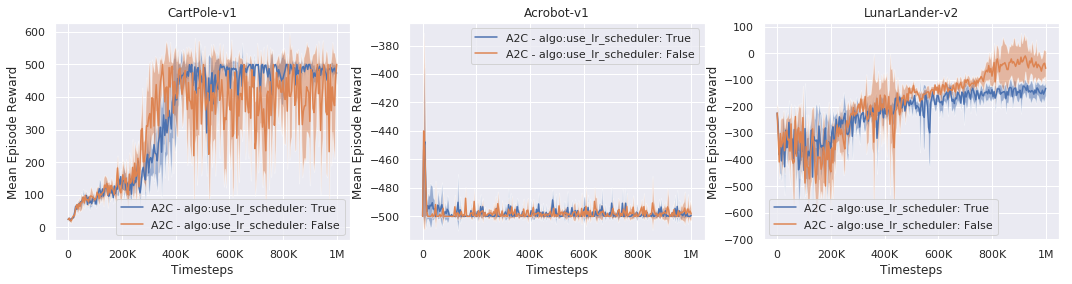

In [102]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'algo:use_lr_scheduler'
compare_values = configs[compare_key].unique().tolist()
print(f'{compare_key}: {compare_values}')

compare_results('A2C', log_folder, envs, compare_key, compare_values)

## 3.3. Discount factor

In [134]:
log_folder = 'a2c/logs/gamma'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                        
True 0.001   0.950      False                 CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/gamma/CartPole-v1 0   0   
                                                                                                                                                                                                                            1   4   
                                                                                                                                                                                                                            2   8   
                                                                                                                                                                                                                            3  12   
                                                                                                                                                                                                                            4  16   
             0.990      False                 CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/gamma/CartPole-v1 0   1   
                                                                                                                                                                                                                            1   5   
                                                                                                                                                                                                                            2   9   
                                                                                                                                                                                                                            3  13   
                                                                                                                                                                                                                            4  17   
             0.995      False                 CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/gamma/CartPole-v1 0   2   
                                                                                                                                                                                                                            1   6   
                                                                                                                                                                                                                            2  10   
                                                                                                                                                                                                                            3  14   
                                                                                                                                                                                                                            4  18   
             0.998      False                 CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/gamma/CartPole-v1 0   3   
                                                                                                     

algo:gamma: [0.95, 0.99, 0.995, 0.998]


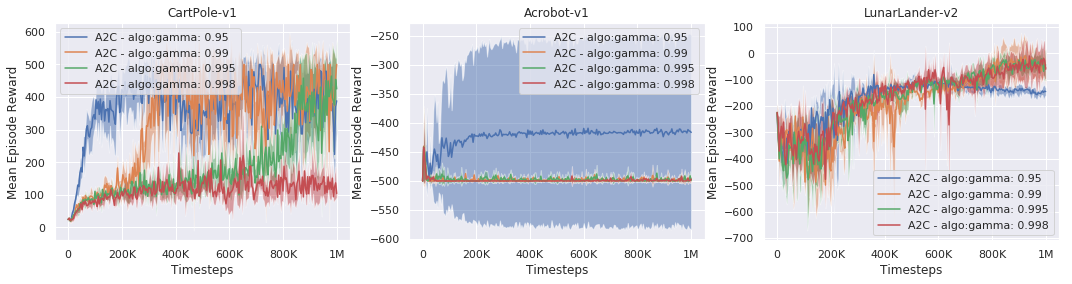

In [135]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'algo:gamma'
compare_values = configs[compare_key].unique().tolist()
print(f'{compare_key}: {compare_values}')

compare_results('A2C', log_folder, envs, compare_key, compare_values)

## 3.4. Normalize observation and reward

In [154]:
log_folder = 'a2c/logs/env_normalize'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/env_normalize/CartPole-v1 0   1   
                                                                                                                                                                                                                                    1   3   
                                                                                                                                                                                                                                    2   5   
                                                                                                                                                                                                                                    3   7   
                                                                                                                                                                                                                                    4   9   
                                                          True          1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/env_normalize/CartPole-v1 0   0   
                                                                                                                                                                                                                                    1   2   
                                                                                                                                                                                                                                    2   4   
                                                                                                                                                                                                                                    3   6   
                                                                                                                                                                                                                                    4   8   

                                                                                                                                                                                                                                             seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                       
True 0.001   0.99       False                 CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              50           logs/env_normalize/CartPole-v1 0   144682090  
                                                                                                                                                                                                                                    1   591442434  
                                                                                                                                                                                                                                    2  1746958036  
                                                                                                                                                                      

env:normalize: [True, False]


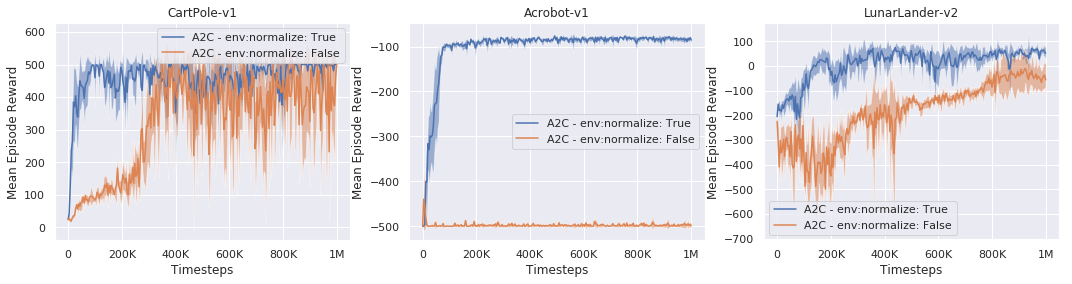

In [155]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'env:normalize'
compare_values = configs[compare_key].unique().tolist()
print(f'{compare_key}: {compare_values}')

compare_results('A2C', log_folder, envs, compare_key, compare_values)

## 3.5. Training trajectories

In [ ]:
log_folder = 'a2c/logs/train_N'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.6. Training timesteps

In [ ]:
log_folder = 'a2c/logs/train_T'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.7. Standardize returns

In [49]:
log_folder = 'a2c/logs/agent_standardize'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

ID  \
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                    
True 0.0005  0.99       True                  CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              100          logs/agent_standardize/CartPole-v1 0   1   
                                                                                                                                                                                                                                        1   3   
                                                                                                                                                                                                                                        2   5   
                                                                                                                                                                                                                                        3   7   
                                                                                                                                                                                                                                        4   9   
                                                                                                              True              0.5                 0.01               0.5              100          logs/agent_standardize/CartPole-v1 0   0   
                                                                                                                                                                                                                                        1   2   
                                                                                                                                                                                                                                        2   4   
                                                                                                                                                                                                                                        3   6   
                                                                                                                                                                                                                                        4   8   

                                                                                                                                                                                                                                                 seed  
cuda algo:lr algo:gamma algo:use_lr_scheduler env:id      env:normalize train:timestep train:N train:T eval:N agent:standardize agent:max_grad_norm agent:entropy_coef agent:value_coef log:interval log:dir                                           
True 0.0005  0.99       True                  CartPole-v1 False         1000000.0      16      5       10     False             0.5                 0.01               0.5              100          logs/agent_standardize/CartPole-v1 0   144682090  
                                                                                                                                                                                                                                        1   591442434  
                                                                                                                                                                                                                                        2  1746958036  
                                                                                                      

agent:standardize: [True, False]


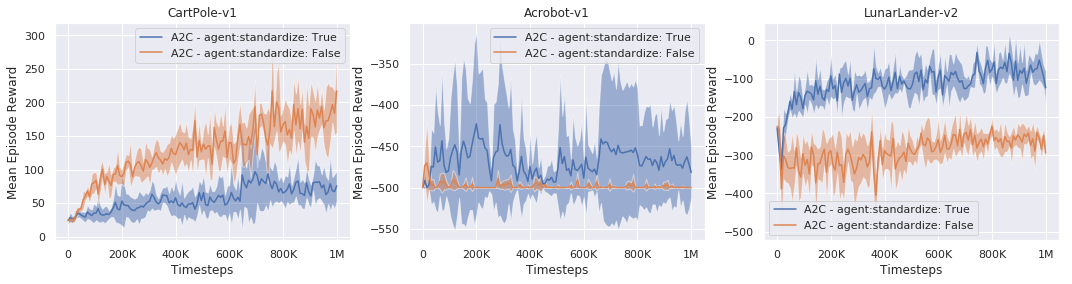

In [50]:
envs = ['CartPole-v1', 'Acrobot-v1', 'LunarLander-v2']

compare_key = 'agent:standardize'
compare_values = configs[compare_key].unique().tolist()
print(f'{compare_key}: {compare_values}')

compare_results('A2C', log_folder, envs, compare_key, compare_values)

## 3.8. Gradient clipping

In [ ]:
log_folder = 'a2c/logs/grad_clip'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.9. Entropy coefficient

In [ ]:
log_folder = 'a2c/logs/entropy_coef'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.10. Initialization method

In [ ]:
log_folder = 'a2c/logs/init_method'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.11. Initialization scale

In [ ]:
log_folder = 'a2c/logs/init_scale'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.12. Nonlinearity

In [ ]:
log_folder = 'a2c/logs/nonlinearity'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.13. Number of hidden neurons

In [ ]:
log_folder = 'a2c/logs/hidden_neurons'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.14. Number of layers

In [ ]:
log_folder = 'a2c/logs/hidden_layers'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.15. Value coefficient

In [ ]:
log_folder = 'a2c/logs/value_coef'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.16. Standardize advantage

In [ ]:
log_folder = 'a2c/logs/standardize_adv'
vis_env = 'CartPole-v1'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.17. Min standard deviation

In [ ]:
log_folder = 'a2c/logs/min_std'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.18. Constant standard deviation

In [ ]:
log_folder = 'a2c/logs/constant_std'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.19. State dependency for standard deviation

In [ ]:
log_folder = 'a2c/logs/std_state'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.20. Standard deviation parameterization

In [ ]:
log_folder = 'a2c/logs/std_parameterization'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

## 3.21. Initialization of standard deviation

In [ ]:
log_folder = 'a2c/logs/init_std'
vis_env = 'Reacher-v2'

configs = Config.to_pandas_dataframe(np.load(f'{log_folder}/{vis_env}/configs.npy'))
grouped_configs, vis_group = Config.partition_IDs(configs, ['seed'])
vis_group

# 4. Benchmark REINFORCE/VPG/A2C